# Wikipedia Album Detail Embedding

Experiment to see if vectors extracted from album details of Wikipedia have useful clustering.

The grouping obtained on album details do not seem that powerful. It looks to me like artist pages have more descriptions about style and influence than album detail pages.

Album detail pages may be good for finding specific features though such as sales.


In [1]:
import os
import re
from urllib.parse import urljoin
import datetime as dt

import requests
from bs4 import BeautifulSoup
import sqlite3
import pandas as pd
import numpy as np
import scipy
import scipy.sparse

import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

from IPython.display import display, HTML, clear_output

In [4]:
%run ./url_cache.ipynb
%run ./wikipedia_access.ipynb
%run ./wikipedia_album_detail_lib.ipynb

## Configure DB and Load Album Extract

In [5]:
db = sqlite3.Connection("var/data/music.db")

In [6]:
url_cache = URLContentCacheSqlite(db)

wayl_db = WikipediaAlbumYearListsDB(db)
albums = wayl_db.get_all()

### Get Albums With Detail Links

In [7]:
def get_album_link(links):
    if links is not None and 'Album' in links and len(links['Album']) > 0:
        return links['Album'][0]['href']
    
albums['AlbumLink'] = albums.Links.apply(get_album_link)

In [8]:
albums_w_detail_links = albums[albums.AlbumLink.notnull()]

## Build Document Word Lists

In [9]:
ad_word_retriever = AlbumDetailWPDocWordsRetriever(url_cache, db)

In [10]:
ad_word_retriever.process_albums(albums)

[2021-10-26 16:42:09.693468] Processed 1000 albums.
[2021-10-26 16:42:11.434564] Processed 2000 albums.
[2021-10-26 16:42:13.448477] Processed 3000 albums.
[2021-10-26 16:42:15.213198] Processed 4000 albums.
[2021-10-26 16:42:17.018852] Processed 5000 albums.
[2021-10-26 16:42:18.909531] Processed 6000 albums.
[2021-10-26 16:42:20.770479] Processed 7000 albums.
[2021-10-26 16:42:22.658326] Processed 8000 albums.
[2021-10-26 16:42:24.541681] Processed 9000 albums.
[2021-10-26 16:42:26.456882] Processed 10000 albums.
[2021-10-26 16:42:28.498924] Processed 11000 albums.
[2021-10-26 16:42:30.430400] Processed 12000 albums.
[2021-10-26 16:42:32.237126] Processed 13000 albums.
[2021-10-26 16:42:34.056785] Processed 14000 albums.
[2021-10-26 16:42:35.826887] Processed 15000 albums.
[2021-10-26 16:42:37.561885] Processed 16000 albums.
[2021-10-26 16:42:39.383563] Processed 17000 albums.
[2021-10-26 16:42:41.184892] Processed 18000 albums.
[2021-10-26 16:42:42.995954] Processed 19000 albums.
[2

In [11]:
pd.read_sql("select avg(length(words)), max(length(words)), sum(length(words)) from document_words", db)

,avg(length(words)),max(length(words)),sum(length(words))
0,13678.496174,257213,452197405


In [12]:
pd.read_sql("select * from document_words limit 5", db)

,category,doc_id,words
0,wp_album_year_list_detail,0,"[""mamaru"", ""album"", ""wikipedia"", ""mamaru"", ""al..."
1,wp_album_year_list_detail,1,[]
2,wp_album_year_list_detail,2,[]
3,wp_album_year_list_detail,3,"[""night"", ""call"", ""album"", ""wikipedia"", ""night..."
4,wp_album_year_list_detail,4,[]


## Build Up Word Counts

In [13]:
class WordCounter:
    
    def __init__(self):
        self.word_counts = {}
        self.doc_counts = {}
        self.doc_count = 0
    
    def add_doc(self, doc_words):
        w_counts = WordCounter.count_words(words)
        for w, c in w_counts.items():
            self.word_counts[w] = self.word_counts.get(w, 0) + c
            self.doc_counts[w] = self.doc_counts.get(w, 0) + 1
        self.doc_count += 1
    
    def get_word_info(self):
        word_info = pd.merge(
            pd.DataFrame({'Word': self.word_counts.keys(), 'WordCount': self.word_counts.values() }),
            pd.DataFrame({'Word': self.doc_counts.keys(), 'DocCount': self.doc_counts.values() }),
            on = 'Word'
        )
        word_info['WordPercent'] = 100.0 * word_info['WordCount'] / word_info['WordCount'].sum()
        word_info['DocPercent'] = 100.0 * word_info['DocCount'] / self.doc_count
        word_info['IDF'] = np.log(self.doc_count / (word_info['DocCount'] + 1))
        word_info = word_info.sort_values(by='WordCount', ascending=False).reset_index(drop=True)
        return word_info

    @staticmethod
    def count_words(words):
        wc = {}
        for w in words:
            wc[w] = wc.get(w, 0) + 1
        return wc

In [14]:
c = db.cursor()
c.execute(f"""
    select cast(doc_id as int), words
    from document_words
    where category = 'wp_album_year_list_detail'
""")

counter = WordCounter()

for row in c:
    doc_id = row[0]
    words = json.loads(row[1])
    counter.add_doc(words)

c.close()

In [15]:
word_info = counter.get_word_info()
word_info

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
0,the,2270997,29593,4.733235,89.515714,0.110722
1,of,819337,29593,1.707670,89.515714,0.110722
2,and,738930,29592,1.540085,89.512689,0.110756
3,album,644503,29558,1.343280,89.409843,0.111906
4,in,642121,29592,1.338315,89.512689,0.110756
...,...,...,...,...,...,...
357452,created—for,1,1,0.000002,0.003025,9.712902
357453,slowbeat,1,1,0.000002,0.003025,9.712902
357454,moonscapes,1,1,0.000002,0.003025,9.712902
357455,post-ambient,1,1,0.000002,0.003025,9.712902


In [16]:
word_info.WordCount.describe().astype(int).to_frame()

,WordCount
count,357457
mean,134
std,5480
min,1
25%,1
50%,2
75%,6
max,2270997


In [17]:
word_info.DocCount.describe().astype(int).to_frame()

,DocCount
count,357457
mean,50
std,745
min,1
25%,1
50%,1
75%,4
max,29593


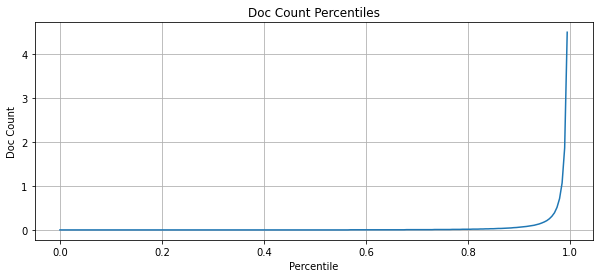

In [18]:
percentiles = np.arange(0.0, 1.0, 0.005)
percentile_values = word_info.DocPercent.quantile(percentiles)

plt.figure(figsize=(10, 4))
plt.title("Doc Count Percentiles")
plt.xlabel("Percentile")
plt.ylabel("Doc Count")
plt.plot(percentiles, percentile_values)
plt.grid(1)
plt.show()

In [22]:
word_info[word_info.Word.isin({'jazz', 'electronic', 'hop', 'hip', 'metal', 'experimental', 'nirvana', 'metallica', 'chains'})]

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
289,metal,28288,5411,0.058958,16.367706,1.809675
513,jazz,13540,3295,0.028220,9.967029,2.305584
582,hop,11584,3955,0.024143,11.963459,2.123060
583,hip,11565,3963,0.024104,11.987658,2.121040
835,electronic,7327,2917,0.015271,8.823618,2.427395
1758,experimental,2782,1723,0.005798,5.211894,2.953647
1931,metallica,2484,481,0.005177,1.454974,4.228105
2804,nirvana,1536,471,0.003201,1.424725,4.249070
2828,chains,1521,427,0.003170,1.291630,4.346926


In [23]:
key_words = word_info[
    (word_info.DocPercent <= 25) &
    (word_info.DocPercent >= 2)
].sort_values(by='DocPercent', ascending=False).reset_index(drop=True)

In [24]:
key_words

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
0,both,15184,8256,0.031647,24.973532,1.387233
1,black,29960,8244,0.062443,24.937233,1.388687
2,industry,24632,8236,0.051338,24.913034,1.389658
3,very,15358,8235,0.032009,24.910009,1.389779
4,again,17844,8219,0.037191,24.861611,1.391724
...,...,...,...,...,...,...
3043,congas,843,662,0.001757,2.002480,3.909274
3044,thrash,1489,662,0.003103,2.002480,3.909274
3045,husband,1029,662,0.002145,2.002480,3.909274
3046,sammy,1882,662,0.003922,2.002480,3.909274


In [25]:
def get_tf(words):
    wc = {}
    for w in words:
        wc[w] = wc.get(w, 0) + 1
    return { w: c / len(words) for w, c in wc.items() }

def get_tf_idf(words, key_words):
    tf = get_tf(words)
    return scipy.sparse.csr.csr_matrix((key_words.Word.apply(tf.get) * key_words.IDF).fillna(0.0))

In [26]:
tfidfs = []
for _, album in albums.iterrows():
    a_words = ad_word_retriever.get_words(album.name, album.AlbumLink)
    a_tfidf = get_tf_idf(a_words, key_words)
    tfidfs.append(a_tfidf)
    if (len(tfidfs) % 1000) == 0:
        print(f"[{dt.datetime.now()}] Computed tf/idf of {len(tfidfs)} docs.")

[2021-10-26 16:48:04.662152] Computed tf/idf of 1000 docs.
[2021-10-26 16:48:10.885887] Computed tf/idf of 2000 docs.
[2021-10-26 16:48:17.378634] Computed tf/idf of 3000 docs.
[2021-10-26 16:48:23.574110] Computed tf/idf of 4000 docs.
[2021-10-26 16:48:30.030750] Computed tf/idf of 5000 docs.
[2021-10-26 16:48:37.297108] Computed tf/idf of 6000 docs.
[2021-10-26 16:48:44.479933] Computed tf/idf of 7000 docs.
[2021-10-26 16:48:51.576192] Computed tf/idf of 8000 docs.
[2021-10-26 16:48:58.748195] Computed tf/idf of 9000 docs.
[2021-10-26 16:49:05.924057] Computed tf/idf of 10000 docs.
[2021-10-26 16:49:12.681069] Computed tf/idf of 11000 docs.
[2021-10-26 16:49:19.242482] Computed tf/idf of 12000 docs.
[2021-10-26 16:49:25.751084] Computed tf/idf of 13000 docs.
[2021-10-26 16:49:32.340493] Computed tf/idf of 14000 docs.
[2021-10-26 16:49:38.863979] Computed tf/idf of 15000 docs.
[2021-10-26 16:49:45.257346] Computed tf/idf of 16000 docs.
[2021-10-26 16:49:51.672252] Computed tf/idf of 1

In [27]:
albums['TFIDF'] = tfidfs

## Cluster Albums

This isn't looking too interesting yet. I am thinking that clustering by Artist is going to be better.

In [97]:
albums_w_links = albums[albums.AlbumLink.notnull()].copy()
albums_emb = scipy.sparse.vstack(albums_w_links.TFIDF)
albums_emb

<29603x3048 sparse matrix of type '<class 'numpy.float64'>'
	with 6390411 stored elements in Compressed Sparse Row format>

In [29]:
import sklearn.metrics

In [98]:
def get_dist(albums):
    pos = 0
    
    scores = []
    score_ids = []
    
    chunk_size = 500
    n = 100
    
    while pos < albums.shape[0]:
        print(f"On pos: {pos}")
        chunk = albums[pos : pos+chunk_size]
        d = sklearn.metrics.pairwise_distances(chunk, albums)
        ds = np.sort(d, axis=1)
        dsid = np.argsort(d, axis=1)
        scores.append(ds[:,0:n])
        score_ids.append(dsid[:,0:n])
        pos += chunk_size
        
    return (np.vstack(scores), np.vstack(score_ids))

In [99]:
scores, score_ids = get_dist(albums_emb)

On pos: 0
On pos: 500
On pos: 1000
On pos: 1500
On pos: 2000
On pos: 2500
On pos: 3000
On pos: 3500
On pos: 4000
On pos: 4500
On pos: 5000
On pos: 5500
On pos: 6000
On pos: 6500
On pos: 7000
On pos: 7500
On pos: 8000
On pos: 8500
On pos: 9000
On pos: 9500
On pos: 10000
On pos: 10500
On pos: 11000
On pos: 11500
On pos: 12000
On pos: 12500
On pos: 13000
On pos: 13500
On pos: 14000
On pos: 14500
On pos: 15000
On pos: 15500
On pos: 16000
On pos: 16500
On pos: 17000
On pos: 17500
On pos: 18000
On pos: 18500
On pos: 19000
On pos: 19500
On pos: 20000
On pos: 20500
On pos: 21000
On pos: 21500
On pos: 22000
On pos: 22500
On pos: 23000
On pos: 23500
On pos: 24000
On pos: 24500
On pos: 25000
On pos: 25500
On pos: 26000
On pos: 26500
On pos: 27000
On pos: 27500
On pos: 28000
On pos: 28500
On pos: 29000
On pos: 29500


In [100]:
score_ids.shape

(29603, 100)

In [103]:
albums_w_links = albums_w_links.reset_index(drop=True)

In [117]:
albums_w_links[albums_w_links.Artist.fillna('').str.contains("King Gizzard")]

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF
366,King Gizzard & the Lizard Wizard,L.W.,,Flightless,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/L.W._(album),"(0, 1)\t0.0011038846485611742\n (0, 9)\t0.0..."
623,King Gizzard & the Lizard Wizard,Butterfly 3000,,,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Butterfly_3000,"(0, 0)\t0.003701754552278126\n (0, 1)\t0.00..."
672,King Gizzard & the Lizard Wizard,Live in Adelaide '19,,King Gizzard & the Lizard Wizard,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/Live_in_Adelaide...,"(0, 2)\t0.0017861923443989814\n (0, 9)\t0.0..."
673,King Gizzard & the Lizard Wizard,Live in Paris '19,,King Gizzard & the Lizard Wizard,2020,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/Live_in_Paris_%2719,"(0, 2)\t0.0018906906720304864\n (0, 9)\t0.0..."
678,King Gizzard & the Lizard Wizard,Live in Brussels '19,,King Gizzard & the Lizard Wizard,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/Live_in_Brussels...,"(0, 0)\t0.0018570716445331027\n (0, 2)\t0.0..."
906,King Gizzard & the Lizard Wizard,Chunky Shrapnel,,Flightless,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/Chunky_Shrapnel,"(0, 4)\t0.0015361188022444048\n (0, 9)\t0.0..."
1396,King Gizzard & the Lizard Wizard,K.G.,Psychedelic rock,Flightless,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/K.G._(album),"(0, 2)\t0.0011938639552769824\n (0, 10)\t0...."
1765,King Gizzard & the Lizard Wizard,Fishing for Fishies,"Boogie rock, blues rock, garage rock",Flightless,2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/Fishing_for_Fishies,"(0, 0)\t0.0009260564208719811\n (0, 2)\t0.0..."
2044,King Gizzard & the Lizard Wizard,Infest the Rats' Nest,Thrash metal,Flightless,2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/Infest_the_Rats%...,"(0, 2)\t0.0015229124865122274\n (0, 6)\t0.0..."
3023,King Gizzard & the Lizard Wizard,Flying Microtonal Banana,"Psychedelic rock, acid rock, krautrock","Flightless, ATO, Heavenly",2017,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2017_albums,https://en.wikipedia.org/wiki/Flying_Microtona...,"(0, 6)\t0.0008958062854920042\n (0, 16)\t0...."


In [118]:
album = albums_w_links[albums_w_links.Album.fillna('').str.contains("Flying Microtonal Banana")].iloc[0]
album

Artist                        King Gizzard & the Lizard Wizard
Album                                 Flying Microtonal Banana
Genre                   Psychedelic rock, acid rock, krautrock
Label                                Flightless, ATO, Heavenly
Year                                                      2017
Links        {'Artist': [{'href': 'https://en.wikipedia.org...
Source       https://en.wikipedia.org/wiki/List_of_2017_albums
AlbumLink    https://en.wikipedia.org/wiki/Flying_Microtona...
TFIDF          (0, 6)\t0.0008958062854920042\n  (0, 16)\t0....
Name: 3023, dtype: object

In [119]:
albums_w_links.loc[score_ids[album.name][0:50]]

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF
3023,King Gizzard & the Lizard Wizard,Flying Microtonal Banana,"Psychedelic rock, acid rock, krautrock","Flightless, ATO, Heavenly",2017,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2017_albums,https://en.wikipedia.org/wiki/Flying_Microtona...,"(0, 6)\t0.0008958062854920042\n (0, 16)\t0...."
1840,Flying Lotus,Flamagra,"Jazz-funk, hip hop, electronic",Warp,2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/Flamagra,"(0, 1)\t0.003476062297596889\n (0, 10)\t0.0..."
2200,Flying Colors,Third Degree,,"Music Theories Recordings, Mascot",2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/Third_Degree_(Fl...,"(0, 1)\t0.0011476751139586421\n (0, 4)\t0.0..."
5645,Flying Colors,Second Nature,,Mascot Label,2014,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2014_albums,https://en.wikipedia.org/wiki/Second_Nature_(F...,"(0, 0)\t0.0007622156694869383\n (0, 3)\t0.0..."
27447,UFO,UFO 2: Flying,None,None,1971,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1971_albums,https://en.wikipedia.org/wiki/UFO_2:_Flying,"(0, 5)\t0.001895820748138129\n (0, 20)\t0.0..."
22160,Chris de Burgh,Flying Colours,None,None,1988,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1988_albums,https://en.wikipedia.org/wiki/Flying_Colours_(...,"(0, 2)\t0.0014108199430887386\n (0, 3)\t0.0..."
10105,Beirut,The Flying Club Cup,"Balkan folk, indie folk, baroque pop","Ba Da Bing!, 4AD",2007,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2007_albums,https://en.wikipedia.org/wiki/The_Flying_Club_Cup,"(0, 3)\t0.0010649647929011313\n (0, 5)\t0.0..."
865,Thundercat,It Is What It Is,,Brainfeeder,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/It_Is_What_It_Is...,"(0, 0)\t0.0005801892590824875\n (0, 1)\t0.0..."
5669,Flying Lotus,You're Dead!,"Electronic, experimental, jazz fusion",Warp,2014,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2014_albums,https://en.wikipedia.org/wiki/You%27re_Dead!,"(0, 0)\t0.001373044393071159\n (0, 3)\t0.00..."
4042,King Gizzard & the Lizard Wizard,Nonagon Infinity,"Psychedelic rock, garage rock, heavy metal","ATO, Flightless",2016,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2016_albums,https://en.wikipedia.org/wiki/Nonagon_Infinity,"(0, 14)\t0.0008877769195768843\n (0, 16)\t0..."


In [278]:
km = MiniBatchKMeans(n_clusters=200)

In [279]:
albums_clusters = km.fit_predict(albums_emb)

In [280]:
albums['Cluster'] = albums_clusters

In [281]:
cluster_counts = albums.groupby('Cluster').size().reset_index().rename(columns={0: 'Count'})

In [282]:
cluster_counts.sort_values(by='Count', ascending=False)

,Cluster,Count
1,1,6852
6,6,3466
149,161,1543
760,805,1427
39,43,1310
...,...,...
544,578,1
543,577,1
537,571,1
532,566,1


In [295]:
def show_other_albums(a_search):
    _albums = albums[albums.Album.fillna('').str.contains(a_search)]
    display(_albums)
    
    if len(_albums) > 0:
        display(albums[albums.Cluster.isin(_albums.Cluster.values)])

In [296]:
show_other_albums('(?i)Ride the light')

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
25977,Metallica,Ride the Lightning,None,None,1984,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1984_albums,https://en.wikipedia.org/wiki/Ride_the_Lightning,351


,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
407,Alien Weaponry,Tangaroa,"Groove metal, thrash metal, alternative metal",Napalm,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Tangaroa_(album),351
894,Labyrinth,Welcome to the Absurd Circus,"Power metal, progressive metal",Frontiers,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Welcome_to_the_A...,351
1022,Korpiklaani,Jylhä,Folk metal,Nuclear Blast,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Jylh%C3%A4,351
1280,The Crown,Royal Destroyer,,Metal Blade,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Royal_Destroyer,351
1391,Genghis Tron,Dream Weapon,,Relapse,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Dream_Weapon,351
...,...,...,...,...,...,...,...,...,...
27871,Judas Priest,Stained Class,None,None,1978,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1978_albums,https://en.wikipedia.org/wiki/Stained_Class,351
28090,Judas Priest,Killing Machine,None,None,1978,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1978_albums,https://en.wikipedia.org/wiki/Killing_Machine,351
28525,Judas Priest,Sad Wings of Destiny,None,None,1976,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1976_albums,https://en.wikipedia.org/wiki/Sad_Wings_of_Des...,351


In [297]:
show_other_albums('(?i)Spirit World Field')

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
2961,Aesop Rock,Spirit World Field Guide,,Rhymesayers,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/Spirit_World_Fie...,63


,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
2961,Aesop Rock,Spirit World Field Guide,,Rhymesayers,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/Spirit_World_Fie...,63
3369,Khalid,Free Spirit,R&B,RCA,2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/Free_Spirit_(Kha...,63
3767,Ceremony,In the Spirit World Now,"Post-punk, new wave",Relapse,2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/In_the_Spirit_Wo...,63
4948,Depeche Mode,Spirit,Electronic,Columbia,2017,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2017_albums,https://en.wikipedia.org/wiki/Spirit_(Depeche_...,63
5738,Massive Attack,Ritual Spirit,"Trip hop, electronica",Virgin,2016,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2016_albums,https://en.wikipedia.org/wiki/Ritual_Spirit,63
5821,Lemon Demon,Spirit Phone,Pop,Needlejuice Records,2016,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2016_albums,https://en.wikipedia.org/wiki/Spirit_Phone,63
6562,Lee Kernaghan,Spirit of the Anzacs,Country,ABC Music,2015,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2015_albums,https://en.wikipedia.org/wiki/Spirit_of_the_An...,63
6930,Bring Me the Horizon,That's the Spirit,"Alternative rock, electronic rock, pop rock","Sony Music, Columbia, RCA",2015,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2015_albums,https://en.wikipedia.org/wiki/That%27s_the_Spirit,63
8950,Nelly Furtado,The Spirit Indestructible,"Pop, R&B","Interscope, Mosley, Mushroom",2012,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2012_albums,https://en.wikipedia.org/wiki/The_Spirit_Indes...,63


In [298]:
show_other_albums('(?i)Hot Rats')

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
31039,Frank Zappa,Hot Rats,None,None,1969,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1969_albums,https://en.wikipedia.org/wiki/Hot_Rats,154


,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,Cluster
id,,,,,,,,,
4651,Trisha Yearwood,Let's Be Frank,Country,Gwendolyn Records,2018,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2018_albums,https://en.wikipedia.org/wiki/Let%27s_Be_Frank,154
14550,Frank Zappa,Joe's Corsage,None,None,2004,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2004_albums,https://en.wikipedia.org/wiki/Joe%27s_Corsage,154
14858,Frank Zappa,Quaudiophiliac,None,None,2004,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2004_albums,https://en.wikipedia.org/wiki/Quaudiophiliac,154
14937,Frank Zappa,Joe's Domage,None,None,2004,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2004_albums,https://en.wikipedia.org/wiki/Joe%27s_Domage,154
15245,Frank Zappa,Halloween,None,None,2003,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2003_albums,https://en.wikipedia.org/wiki/Halloween_(Frank...,154
...,...,...,...,...,...,...,...,...,...
31039,Frank Zappa,Hot Rats,None,None,1969,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1969_albums,https://en.wikipedia.org/wiki/Hot_Rats,154
31134,The Mothers of Invention,We're Only in It for the Money,None,None,1968,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1968_albums,https://en.wikipedia.org/wiki/We%27re_Only_in_...,154
31296,The Mothers of Invention,Cruising with Ruben & the Jets,None,None,1968,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1968_albums,https://en.wikipedia.org/wiki/Cruising_with_Ru...,154


## View Sample Details

In [10]:
sample_albums = albums_w_detail_links.sample(5).copy()

sample_albums['AlbumDetailHTML'] = sample_albums.AlbumLink.apply(lambda l: url_cache.get(l)['content'])

In [11]:
display(HTML(sample_albums.iloc[4].AlbumDetailHTML))